In [3]:
import tensorflow as tf
import pandas as  pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
path = 'Image'

In [5]:
datagen = ImageDataGenerator(rescale=1/255,
                             validation_split = 0.2,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             )

In [6]:
train_generator = datagen.flow_from_directory(path,
                                              target_size=(150,150),
                                              batch_size = 32,
                                              class_mode = 'categorical',
                                              subset = 'training'
                                              )

train_generator.image_shape

Found 3008 images belonging to 26 classes.


(150, 150, 3)

In [7]:
validation_generator = datagen.flow_from_directory(path,
                                                   target_size=(150,150),
                                                   batch_size = 20,
                                                   class_mode = "categorical",
                                                   subset="validation")

Found 738 images belonging to 26 classes.


In [8]:
# Import the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Created an instance of the inception model from the local pre-trained weights
local_weights_file = 'tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [9]:
def create_pre_trained_model(local_weights_file):
  """
  Initializes an InceptionV3 model.

  Args:
    local_weights_file (string): path pointing to a pretrained weights H5 file

  Returns:
    pre_trained_model: the initialized InceptionV3 model
  """
  
  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False,
                                  weights = None)

  pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
    layer.trainable = False

  

  return pre_trained_model

In [10]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model

In [11]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


In [12]:
# Define a Callback class that stops training once accuracy reaches 99.9%

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 95% accuracy so cancelling training!")
      self.model.stop_training = True

In [13]:
def output_of_last_layer(pre_trained_model):
  """
  Gets the last layer output of a model

  Args:
    pre_trained_model (tf.keras Model): model to get the last layer output from

  Returns:
    last_output: output of the model's last layer
  """
  
  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)
  

  return last_output

In [14]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [15]:
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


In [16]:
from tensorflow.keras.models import Model

def create_final_model(pre_trained_model, last_output):
  """
  Appends a custom model to a pre-trained model

  Args:
    pre_trained_model (tf.keras Model): model that will accept the train/test inputs
    last_output (tensor): last layer output of the pre-trained model

  Returns:
    model: the combined model
  """
  # Flatten the output layer to 1 dimension
  x = tf.keras.layers.Flatten()(last_output)
  

  # Add a fully connected layer with 1024 hidden units and ReLU activation
  x = tf.keras.layers.Dense(1024, activation='relu')(x)
  # Add a dropout rate of 0.2
  x = tf.keras.layers.Dropout(.2)(x)
  # Add a final sigmoid layer for classification
  x = tf.keras.layers.Dense(26, activation='softmax')(x)

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)

  model.compile(optimizer = 'Adam',
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])


  return model

In [17]:
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,538,106 total parameters in this model.
There are 38,562,842 trainable parameters in this model.


In [43]:
callbacks = myCallback()

history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 10
                    # callbacks=callbacks
)

Epoch 1/10
95/95 [==============================] - 98s 1s/step - loss: 0.1119 - accuracy: 0.9661 - val_loss: 0.0930 - val_accuracy: 0.9702
Epoch 2/10
95/95 [==============================] - 102s 1s/step - loss: 0.0568 - accuracy: 0.9841 - val_loss: 0.1672 - val_accuracy: 0.9621
Epoch 3/10
95/95 [==============================] - 96s 1s/step - loss: 0.0595 - accuracy: 0.9797 - val_loss: 0.2544 - val_accuracy: 0.9405
Epoch 4/10
95/95 [==============================] - 95s 995ms/step - loss: 0.0771 - accuracy: 0.9751 - val_loss: 0.1034 - val_accuracy: 0.9689
Epoch 5/10
95/95 [==============================] - 104s 1s/step - loss: 0.0567 - accuracy: 0.9834 - val_loss: 0.1073 - val_accuracy: 0.9811
Epoch 6/10
95/95 [==============================] - 94s 988ms/step - loss: 0.0674 - accuracy: 0.9794 - val_loss: 0.2700 - val_accuracy: 0.9391
Epoch 7/10
95/95 [==============================] - 91s 954ms/step - loss: 0.0682 - accuracy: 0.9821 - val_loss: 0.1644 - val_accuracy: 0.9608
Epoch 8/1

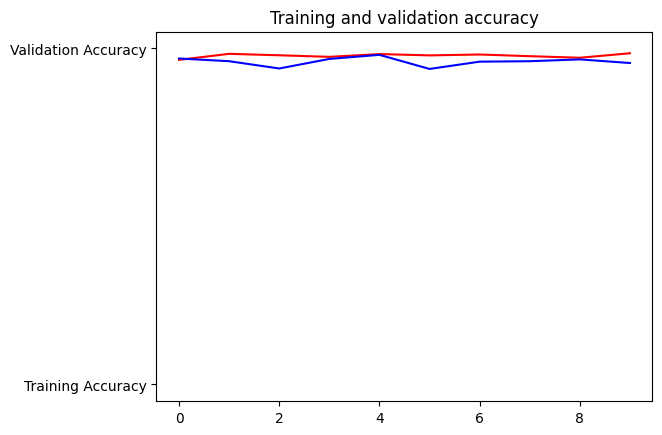

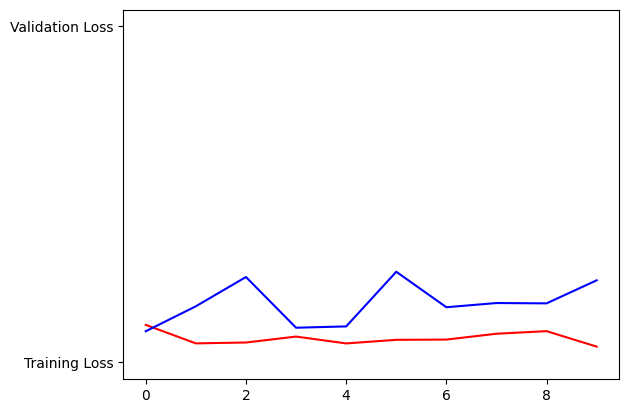

In [44]:
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [25]:
from tensorflow.keras.models import save_model  

model.save('4th_Sign_model.h5')

In [18]:
callbacks = myCallback()

history_2 = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 10,
                    callbacks=callbacks
)

Epoch 1/10
94/94 [==============================] - 102s 1s/step - loss: 1.3495 - accuracy: 0.7410 - val_loss: 0.2679 - val_accuracy: 0.9146
Epoch 2/10
94/94 [==============================] - ETA: 0s - loss: 0.1452 - accuracy: 0.9588
Reached 95% accuracy so cancelling training!
94/94 [==============================] - 93s 988ms/step - loss: 0.1452 - accuracy: 0.9588 - val_loss: 0.2177 - val_accuracy: 0.9377


In [19]:
from tensorflow.keras.models import save_model  

model.save('5th_Sign_model.h5')